In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Requirements : 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from osgeo import gdal
import sys
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
from torchvision import datasets, transforms
import helper
from __future__ import print_function, division
import natsort 
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

In [ ]:
## read cropped image as Array : 

def npy_to_matrix(path): 
 # print(path)
  with open(path, 'rb') as f:
    data = np.load(f)
  return data

In [ ]:
## read tif image as Array : 

def tif_to_matrix(path):
  if path != '/content/drive/MyDrive/soilMoisture/Sentinel_images/20200204T112149_20200204T112602_T29TQF.tif' :

    src_ds = gdal.Open(path)
    data = src_ds.ReadAsArray()
    return data 

In [ ]:
# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

In [ ]:
## Create a Customized dataset class for Pytorch : 

class CustomDataSet(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        
    def __len__(self):
        return len(self.landmarks_frame)
        

    def __getitem__(self, idx):

      if torch.is_tensor(idx):
        idx = idx.tolist()

      img_name = self.landmarks_frame.iloc[idx, -1]
      img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, -1])
      image = tif_to_matrix(img_name).astype(float) 

      soilreadings = self.landmarks_frame.iloc[idx, 1]
      
      soilreadings = np.array(soilreadings).astype(float)
      sample = {'image': image, 'soilreadings': soilreadings}
      #print(sample['image'].shape)
      #sample = {'image': img_name, 'soilreadings': soilreadings}
      if self.transform:
          sample = self.transform(sample)

      return sample

In [ ]:
from skimage.transform import resize

In [ ]:
## Transofrm functions : 

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, soilreadings = sample['image'], sample['soilreadings']

        h, w = image.shape[1:]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        image = image.transpose((1, 2, 0))
        img = resize(image, (new_h, new_w))
        
        # h and w are swapped for soilreadings because for images,
        # x and y axes are axis 1 and 0 respectively
        #soilreadings = soilreadings * [new_w / w, new_h / h]

        return {'image': img, 'soilreadings': soilreadings}

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, soilreadings = sample['image'], sample['soilreadings']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        soilreadings = soilreadings - [left, top]

        return {'image': image, 'soilreadings': soilreadings}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, soilreadings = sample['image'], sample['soilreadings']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.tensor(image).float(),
                'soilreadings': torch.tensor(soilreadings).float()}

In [ ]:
## Defind the parameters : 

scale = Rescale(128)
crop = RandomCrop(64)
composed = transforms.Compose([Rescale(128),
                               RandomCrop(64)])

In [ ]:
## Read the Customized dataset as tensors :
train_dataset = CustomDataSet(csv_file='/content/drive/MyDrive/Datasets/DataTrain.csv', 
                                    root_dir='/content/drive/MyDrive/soilMoisture/Sentinel_images',
                                           transform=transforms.Compose([ Rescale((224,224)),ToTensor()]))

validation_dataset = CustomDataSet(csv_file='/content/drive/MyDrive/Datasets/DataTest', 
                                    root_dir='/content/drive/MyDrive/soilMoisture/Images_test',
                                           transform=transforms.Compose([ Rescale((224,224)),ToTensor()]))


In [ ]:
train_loader = DataLoader(train_dataset,batch_size=3,shuffle=False,num_workers=2)
validation_loader = DataLoader(validation_dataset,batch_size=3,shuffle=False,num_workers=2)

In [ ]:
## Split the dataloader to train and validation loaders :

batch_size = 4
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(transformed_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=batch_size,drop_last=True , 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=batch_size,drop_last=True ,
                                                sampler=valid_sampler)

In [ ]:
## Switch the work to the GPU : 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
## Model Architecture : 

class CNN(nn.Module): 
    def __init__(self, in_channels=12, num_classes = 1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=(3,3), stride=(1,1), padding=(1,1) )
        self.conv2 = nn.Conv2d(20, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv2_drop = nn.Dropout2d(p=0.4)
        
        self.fc1 = nn.Linear(8448, num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size()[0],-1)
        x = F.relu(self.fc1(x))  ## relu
      
        return x

In [ ]:
## Model to GPU :

model = CNN()
model = CNN().to(device)

In [ ]:
## Running time parameters : 

epochs = 30
num_epochs = 30
batch_size = 8
learning_rate = 0.001

In [ ]:
## Loss Function : 

def rmseLoss(output, target):
  loss_fn = nn.MSELoss()
  a = torch.sqrt(loss_fn(output.float(), target.float()))
  return a.float() 
  
criterion=rmseLoss

In [ ]:
## Optimizer : 

optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [ ]:
## Train the Model : 

%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []
pred_Val = []
target_Val = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in enumerate(train_loader):
        # move-tensors-to-GPU 
        #print(target)
        data = target['image']
        target = target['soilreadings']

        if data.dtype != 'NoneType' :
          #data = normalize(data)
          #data = data.float()
          data= data.type(torch.cuda.FloatTensor)
          data = data.to(device)
          target = target.to(device)
          # clear-the-gradients-of-all-optimized-variables
          optimizer.zero_grad()
          # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
          output = model(data)
          # calculate-the-batch-loss
          loss = criterion(output, target)
          optimizer.zero_grad()
          # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
          loss.backward()
          # perform-a-ingle-optimization-step (parameter-update)
          optimizer.step()
          # update-training-loss
          train_loss += loss.item() * data.size(0)
          pred_Val.append(output)
          target_Val.append(target)


    # validate-the-model
    model.eval()
    for data, target in enumerate(validation_loader):
        data = target['image']
        target = target['soilreadings']
        if data.dtype != 'NoneType' :
          data = normalize(data)      
          data = data.float()
          data = data.to(device)
          target = target.to(device)
          
          output = model(data)
          
          loss = criterion(output, target)
          data.size()
          # update-average-validation-loss 
          valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(validation_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.371869 	Validation Loss: 0.193654
Epoch: 2 	Training Loss: 0.121470 	Validation Loss: 0.193654
Epoch: 3 	Training Loss: 0.121470 	Validation Loss: 0.193654
Epoch: 4 	Training Loss: 0.121470 	Validation Loss: 0.193654
Epoch: 5 	Training Loss: 0.121470 	Validation Loss: 0.193654
Epoch: 6 	Training Loss: 0.121470 	Validation Loss: 0.193654
Epoch: 7 	Training Loss: 0.121470 	Validation Loss: 0.193654
Epoch: 8 	Training Loss: 0.121470 	Validation Loss: 0.193654
Epoch: 9 	Training Loss: 0.121470 	Validation Loss: 0.193654
Epoch: 10 	Training Loss: 0.121470 	Validation Loss: 0.193654
Epoch: 11 	Training Loss: 0.121470 	Validation Loss: 0.193654
Epoch: 12 	Training Loss: 0.121470 	Validation Loss: 0.193654
Epoch: 13 	Training Loss: 0.121470 	Validation Loss: 0.193654
Epoch: 14 	Training Loss: 0.121470 	Validation Loss: 0.193654
Epoch: 15 	Training Loss: 0.121470 	Validation Loss: 0.193654
Epoch: 16 	Training Loss: 0.121470 	Validation Loss: 0.193654
Epoch: 17 	Traini

In [ ]:
class GoogLeNet(nn.Module):

    def __init__(self, aux_logits=True, num_classes=1):
        super(GoogLeNet, self).__init__()
        assert aux_logits == True or aux_logits == False
        self.aux_logits = aux_logits

        # Write in_channels, etc, all explicit in self.conv1, rest will write to
        # make everything as compact as possible, kernel_size=3 instead of (3,3)
        self.conv1 = conv_block(
            in_channels=12,
            out_channels=64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3),
        )

        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # In this order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)

        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)
        self.sigmoid=nn.Sigmoid()

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
        else:
            self.aux1 = self.aux2 = None
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        # x = self.conv3(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)

        # Auxiliary Softmax classifier 1
        if self.aux_logits and self.training:
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)

        # Auxiliary Softmax classifier 2
        if self.aux_logits and self.training:
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))

        

        if self.aux_logits and self.training:
            return aux1, aux2, x
        else:
            return x


class Inception_block(nn.Module):
    def __init__(
        self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    ):
        super(Inception_block, self).__init__()
        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=(1, 1))

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=(1, 1)),
            conv_block(red_3x3, out_3x3, kernel_size=(3, 3), padding=(1, 1)),
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=(1, 1)),
            conv_block(red_5x5, out_5x5, kernel_size=(5, 5), padding=(2, 2)),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            conv_block(in_channels, out_1x1pool, kernel_size=(1, 1)),
        )

    def forward(self, x):
        return torch.cat(
            [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1
        )


class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.7)
        self.pool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = conv_block(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))


if __name__ == "__main__":
    # N = 3 (Mini batch size)
    x = torch.randn(6, 12, 224, 224)
    model = GoogLeNet(aux_logits=True, num_classes=1)
    print(model(x)[2].shape)

torch.Size([6, 1])


In [ ]:
model = GoogLeNet(aux_logits=True, num_classes=1)
model = GoogLeNet(aux_logits=True, num_classes=1).to(device)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [ ]:
## Train the Model : 

%%time

# keeping-track-of-losses 
train_losses = []
valid_losses = []
pred_Val = []
target_Val = []
criterion = nn.MSELoss()

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in enumerate(train_loader):
        # move-tensors-to-GPU 
        #print(target)
        data = target['image']
        target = target['soilreadings']
        
        #data = normalize(data)
        data = data.float()

        data = data.to(device)
        target = target.to(device)
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        output=output[2]
        loss = criterion(output, target)
        optimizer.zero_grad()

        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        pred_Val.append(output.cpu().data.numpy())
        target_Val.append(target.cpu().data.numpy())
        
    # validate-the-model
    model.eval()
    for data, target in enumerate(validation_loader):
        data = target['image']
        target = target['soilreadings']
        if data.dtype != 'NoneType' :
          data = normalize(data)      
          data = data.float()
          data = data.to(device)
          target = target.to(device)
          
          output = model(data)
          output=output[2]
          loss = criterion(output, target)
          data.size()
          # update-average-validation-loss 
          valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(validation_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.056704 	Validation Loss: 0.037505
Epoch: 2 	Training Loss: 0.017775 	Validation Loss: 0.037505
Epoch: 3 	Training Loss: 0.017775 	Validation Loss: 0.037505
Epoch: 4 	Training Loss: 0.017775 	Validation Loss: 0.037505
Epoch: 5 	Training Loss: 0.017775 	Validation Loss: 0.037505
Epoch: 6 	Training Loss: 0.017775 	Validation Loss: 0.037505
Epoch: 7 	Training Loss: 0.017775 	Validation Loss: 0.037505
Epoch: 8 	Training Loss: 0.017775 	Validation Loss: 0.037505
Epoch: 9 	Training Loss: 0.017775 	Validation Loss: 0.037505
Epoch: 10 	Training Loss: 0.017775 	Validation Loss: 0.037505
Epoch: 11 	Training Loss: 0.017775 	Validation Loss: 0.037505
Epoch: 12 	Training Loss: 0.017775 	Validation Loss: 0.037505
Epoch: 13 	Training Loss: 0.017775 	Validation Loss: 0.037505
Epoch: 14 	Training Loss: 0.017775 	Validation Loss: 0.037505
Epoch: 15 	Training Loss: 0.017775 	Validation Loss: 0.037505
Epoch: 16 	Training Loss: 0.017775 	Validation Loss: 0.037505
Epoch: 17 	Traini

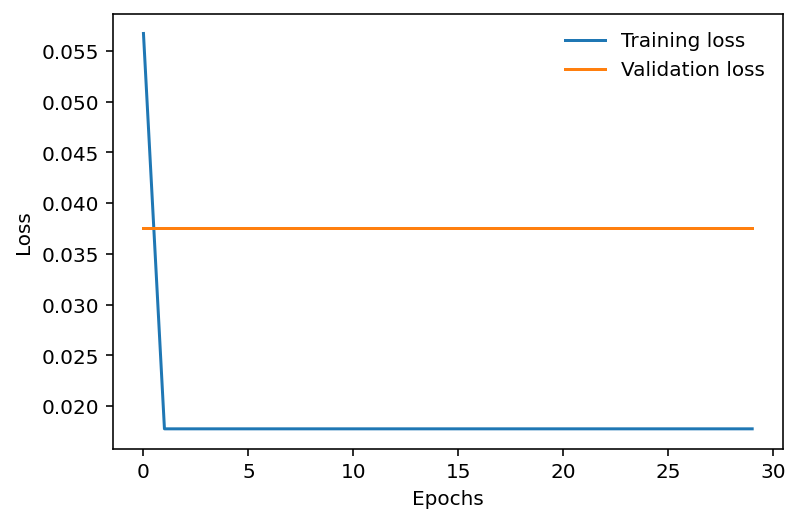

In [ ]:
## Visualize the Train & validation losses :
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [ ]:
L = []
for e in pred_Val:
  for i in range(len(e)):
    L.append(float(e[i]))

In [ ]:
L1 = []
for e in target_Val:
  for i in range(len(e)):
    L1.append(float(e[i]))

In [ ]:
import plotly.figure_factory as ff

np.random.seed(1)

x = L
hist_data = [x]
group_labels = ['distplot'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels)
fig.show()

In [ ]:
import plotly.figure_factory as ff

np.random.seed(1)

x = L1
hist_data = [x]
group_labels = ['distplot'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels)
fig.show()